# Mantenimiento Predictivo de Turbinas

Durante la vida útil de las turbinas, estas sufren desgaste, que impacta directamente en su confiabilidad y performance.
Esta notebook es para crear un modelo reutilizable, que en este caso es para predecir la vida util restante (RUL: remaining useful life) de turbinas, basado en data sobre el ciclo de vida completo de las mismas para planificar mejor su mantenimiento.

<img src='_src/turbofan-operation-lbp.png'>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# venv/Scripts/Activate.ps1

#### Definimos nombres de variables

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i+1}' for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

#### Importamos la data de entrenamiento y de validación.

In [3]:
dftrain = pd.read_csv('_data/train_FD002.txt',sep='\s+',header=None,index_col=False,names=col_names)

In [4]:
train = dftrain.copy()

train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


In [5]:
train = train.iloc[:10115]

In [6]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,50,217,20.0056,0.7020,100.0,491.19,608.63,1494.94,1272.77,9.35,...,314.24,2388.15,8058.65,9.2997,0.03,369,2324,100.00,24.30,14.5191
10111,50,218,25.0038,0.6200,60.0,462.54,537.63,1271.83,1062.26,7.05,...,164.04,2028.09,7872.23,11.0080,0.02,309,1915,84.93,14.05,8.4241
10112,50,219,35.0063,0.8400,100.0,449.44,557.15,1376.43,1146.92,5.48,...,182.32,2387.92,8059.87,9.4143,0.02,338,2223,100.00,14.63,8.7040
10113,50,220,20.0009,0.7000,100.0,491.19,608.45,1500.97,1269.84,9.35,...,314.12,2388.24,8060.53,9.3144,0.03,369,2324,100.00,24.34,14.4817


In [7]:
train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

Cantidad de ciclos de cada unidad.

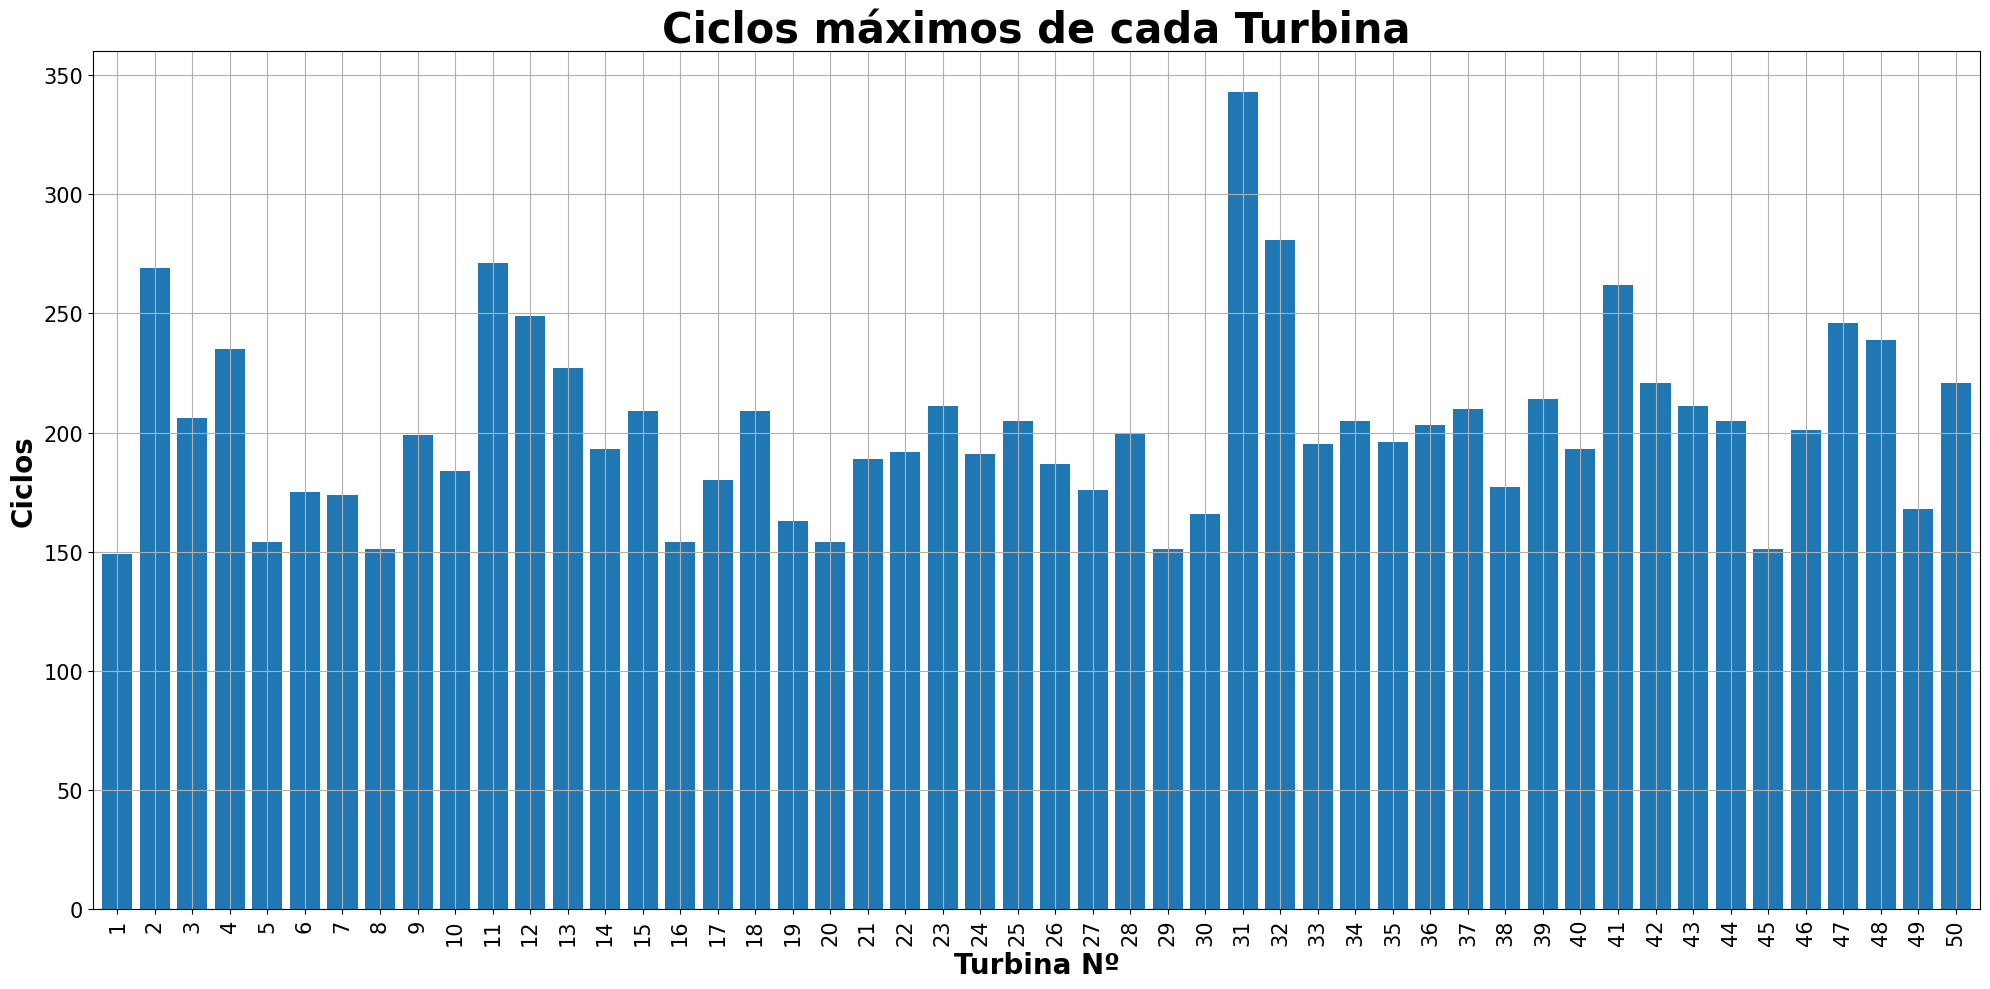

In [8]:
ciclos_maximos = train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,10))
ax = ciclos_maximos['time_cycles'].plot(kind='bar', width=0.8, stacked=True, align='center')
plt.title('Ciclos máximos de cada Turbina',fontweight='bold',size=30)
plt.xlabel('Turbina Nº',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('Ciclos',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'Ciclos máximos')

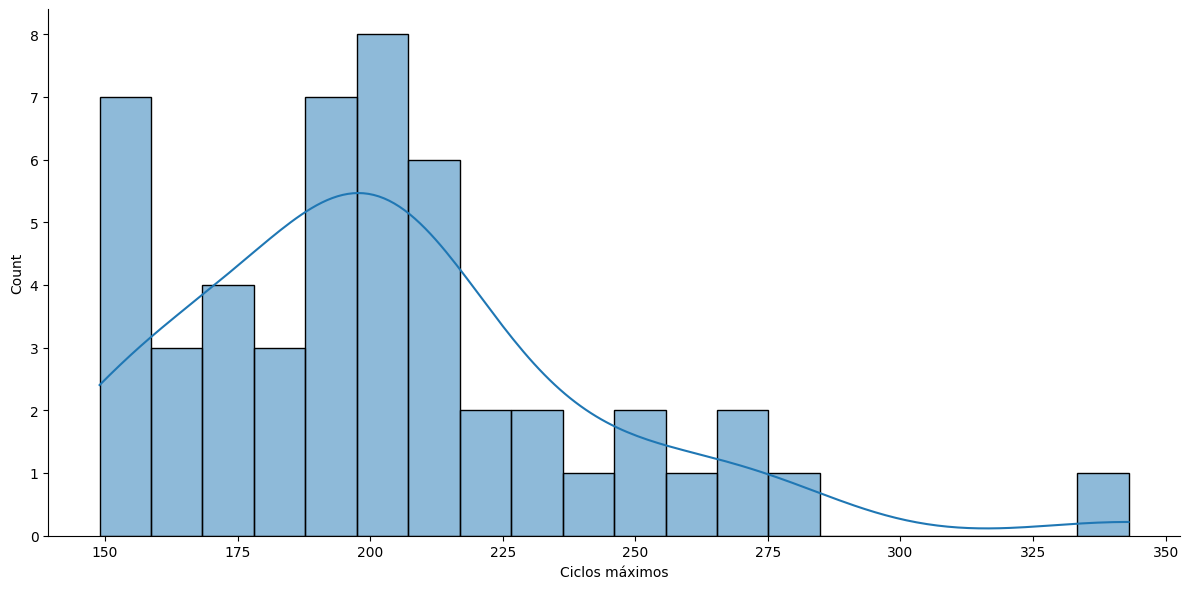

In [9]:
sns.displot(ciclos_maximos['time_cycles'], kde=True, bins=20, height=6, aspect=2)
plt.xlabel('Ciclos máximos')

---

### Añadimos la columna RUL y la clasificación de riesgo a la data.

Indica los ciclos restantes de cada unidad antes de que falle.

In [10]:
def add_RUL_and_risk(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
    mask = merged[merged["max_time_cycle"] == merged["time_cycles"]]
    index = list(mask.index)
    merged["risk"] = np.nan
    for n in index:
        merged.iloc[n-39 : n+1]["risk"].replace(np.nan, 2, inplace=True)
        merged.iloc[n-19 : n+1]["risk"].replace(2, 3, inplace=True)
    merged["risk"].replace(np.nan, 1, inplace=True)
    merged["risk"] = merged["risk"].astype(int)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [11]:
train = add_RUL_and_risk(train)

In [12]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,risk,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,1,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,1,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,1,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,1,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,1,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,50,217,20.0056,0.7020,100.0,491.19,608.63,1494.94,1272.77,9.35,...,8058.65,9.2997,0.03,369,2324,100.00,24.30,14.5191,3,4
10111,50,218,25.0038,0.6200,60.0,462.54,537.63,1271.83,1062.26,7.05,...,7872.23,11.0080,0.02,309,1915,84.93,14.05,8.4241,3,3
10112,50,219,35.0063,0.8400,100.0,449.44,557.15,1376.43,1146.92,5.48,...,8059.87,9.4143,0.02,338,2223,100.00,14.63,8.7040,3,2
10113,50,220,20.0009,0.7000,100.0,491.19,608.45,1500.97,1269.84,9.35,...,8060.53,9.3144,0.03,369,2324,100.00,24.34,14.4817,3,1


### Preparamos la data para ML.

In [13]:
drop_labels = index_names + setting_names + ['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19', 'RUL']

X_train = train.drop(columns=drop_labels).copy()

In [14]:
X_train

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,risk
0,555.32,1358.61,1137.23,194.64,2222.65,8341.91,42.02,183.06,2387.72,8048.56,9.3461,334,14.73,8.8071,1
1,549.90,1353.22,1125.78,138.51,2211.57,8303.96,42.20,130.42,2387.66,8072.30,9.3774,330,10.41,6.2665,1
2,537.31,1256.76,1047.45,175.71,1915.11,8001.42,36.69,164.22,2028.03,7864.87,10.8941,309,14.08,8.6723,1
3,549.51,1354.03,1126.38,138.46,2211.58,8303.96,41.96,130.72,2387.61,8068.66,9.3528,329,10.59,6.4701,1
4,537.07,1257.71,1047.93,175.05,1915.10,7993.23,36.89,164.31,2028.00,7861.23,10.8963,309,14.13,8.5286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,608.63,1494.94,1272.77,333.41,2324.13,8733.45,45.08,314.24,2388.15,8058.65,9.2997,369,24.30,14.5191,3
10111,537.63,1271.83,1062.26,174.76,1915.18,8011.63,37.21,164.04,2028.09,7872.23,11.0080,309,14.05,8.4241,3
10112,557.15,1376.43,1146.92,193.91,2222.84,8353.36,42.64,182.32,2387.92,8059.87,9.4143,338,14.63,8.7040,3
10113,608.45,1500.97,1269.84,332.58,2324.10,8722.86,44.84,314.12,2388.24,8060.53,9.3144,369,24.34,14.4817,3


In [15]:

X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['risk'], test_size=0.3, random_state=137)

In [16]:
label_map={1:"LOW", 2:"MEDIUM", 3:"HIGH"}

In [17]:
scaler = MinMaxScaler()

# Eliminamos la variable a predecir
X_train.drop(columns=['risk'], inplace=True)
X_test.drop(columns=['risk'], inplace=True)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

Vamos a usar el error absoluto promedio, para evaluar los modelos

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

---

## MACHINE LEARNING

### SVC

In [19]:
classifier = SVC(kernel = 'linear', random_state = 137)

In [20]:
classifier.fit(X_train, y_train)

y_svc_train = classifier.predict(X_train)

y_svc_test = classifier.predict(X_test)

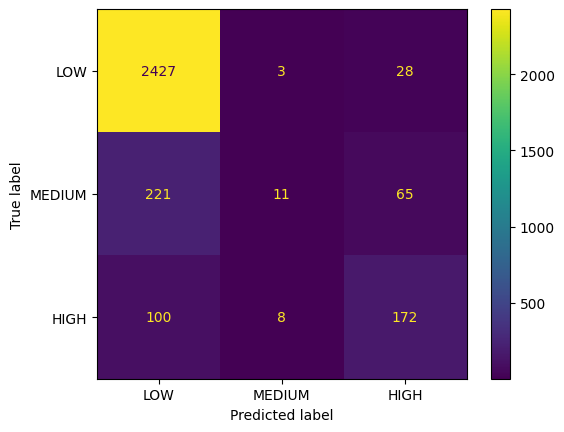

SVM
Accuracy score of training 0.867
Error rate of training 0.080
Accuracy score of test 0.860
Error rate of test 0.089
              precision    recall  f1-score   support

           1       0.88      0.99      0.93      2458
           2       0.50      0.04      0.07       297
           3       0.65      0.61      0.63       280

    accuracy                           0.86      3035
   macro avg       0.68      0.55      0.54      3035
weighted avg       0.82      0.86      0.82      3035



In [21]:
cm = confusion_matrix(y_test, y_svc_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]], label_map[classifier.classes_[1]], label_map[classifier.classes_[2]]])
disp.plot()
plt.show()

# Performance
print('SVM')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_svc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train, y_svc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_svc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test, y_svc_test))
print(metrics.classification_report(y_test, y_svc_test))

### Random Forest

In [22]:
clf = RandomForestClassifier(n_estimators=100)

In [23]:
clf.fit(X_train, y_train)

y_rfc_train = clf.predict(X_train)

y_rfc_test = clf.predict(X_test)

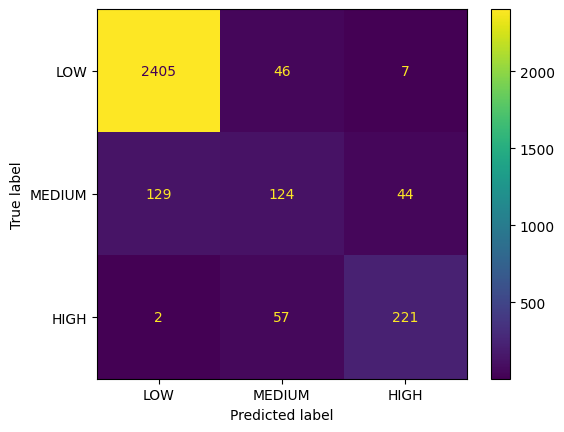

RFC
Accuracy score of training 1.000
Error rate of training 0.000
Accuracy score of test 0.906
Error rate of test 0.055
              precision    recall  f1-score   support

           1       0.95      0.98      0.96      2458
           2       0.55      0.42      0.47       297
           3       0.81      0.79      0.80       280

    accuracy                           0.91      3035
   macro avg       0.77      0.73      0.75      3035
weighted avg       0.90      0.91      0.90      3035



In [24]:
cm = confusion_matrix(y_test, y_rfc_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]], label_map[clf.classes_[1]], label_map[clf.classes_[2]]])
disp.plot()
plt.show()

# Performance
print('RFC')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_rfc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train, y_rfc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_rfc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test, y_rfc_test))
print(metrics.classification_report(y_test, y_rfc_test))

### Naive Bayes

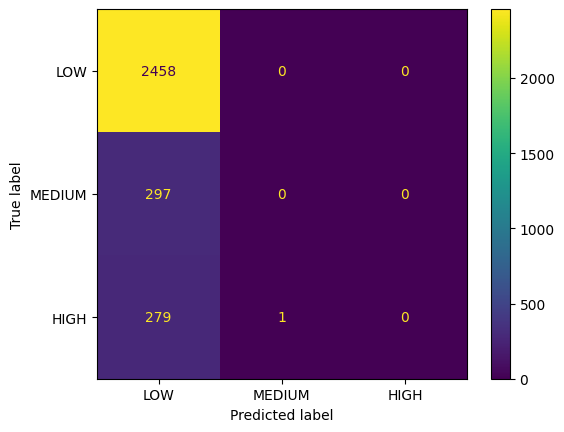

Guassian Naive Bayes
Accuracy score of train 0.799
Error rate of train 0.117
Accuracy score of test 0.810
Error rate of test 0.110
              precision    recall  f1-score   support

           1       0.81      1.00      0.90      2458
           2       0.00      0.00      0.00       297
           3       0.00      0.00      0.00       280

    accuracy                           0.81      3035
   macro avg       0.27      0.33      0.30      3035
weighted avg       0.66      0.81      0.72      3035



In [25]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_gnb_test = gnb.predict(X_test)
y_gnb_train = gnb.predict(X_train)


cm = confusion_matrix(y_test, y_gnb_test, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]], label_map[gnb.classes_[1]], label_map[gnb.classes_[2]]])
disp.plot()
plt.show()

print('Guassian Naive Bayes')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train, y_gnb_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train, y_gnb_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_gnb_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test, y_gnb_test))

print(metrics.classification_report(y_test, y_gnb_test))

### KNN

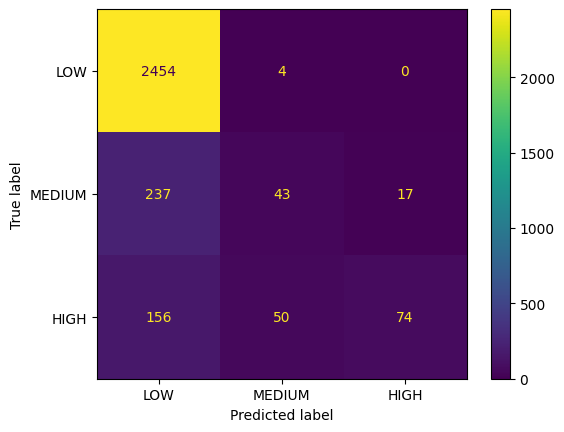

KNN
Accuracy score of train 0.846
Error rate of train 0.085
Accuracy score of test 0.847
Error rate of test 0.083
              precision    recall  f1-score   support

           1       0.86      1.00      0.93      2458
           2       0.44      0.14      0.22       297
           3       0.81      0.26      0.40       280

    accuracy                           0.85      3035
   macro avg       0.71      0.47      0.51      3035
weighted avg       0.82      0.85      0.81      3035



In [26]:

knn = KNeighborsClassifier(n_neighbors=100)

knn.fit(X_train, y_train)

y_knn_test = knn.predict(X_test)
y_knn_train = knn.predict(X_train)

cm = confusion_matrix(y_test, y_knn_test, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]], label_map[knn.classes_[1]], label_map[knn.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('KNN')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train, y_knn_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train, y_knn_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_knn_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test, y_knn_test))

print(metrics.classification_report(y_test, y_knn_test))